<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fquestion-answering/applications/question-answering/Visual%20Question%20Answering%20with%20DMN%20Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DAQUAR dataset

In [1]:
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar

--2020-08-02 16:56:24--  http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.86.170
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar [following]
--2020-08-02 16:56:24--  https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431144960 (411M) [application/x-tar]
Saving to: ‘nyu_depth_images.tar’

nyu_depth_images.ta 100%[===================>] 411.17M   105MB/s    in 4.5s    

2020-08-02 16:56:28 (92.2 MB/s) - ‘nyu_depth_images.tar’ saved [431144960/431144960]



In [2]:
!tar -xf nyu_depth_images.tar

In [3]:
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.test.txt
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/train.txt
!wget http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/test.txt

--2020-08-02 16:56:37--  http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.86.170
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt [following]
--2020-08-02 16:56:37--  https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.86.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 423888 (414K) [text/plain]
Saving to: ‘qa.894.raw.train.txt’

qa.894.raw.train.tx 100%[===================>] 413.95K  --.-KB/s    in 0.08s   

2020-08-02 16:56:38 (4.91 MB/s) - ‘qa.894.raw.train.txt’ saved [423888/423888]

--2020-08-02 16:56:41--  http://datasets.d2.mpi-inf.mpg.de/mateu

In [4]:
!ls

nyu_depth_images      qa.894.raw.test.txt   sample_data  train.txt
nyu_depth_images.tar  qa.894.raw.train.txt  test.txt


### Imports

In [75]:
import os
import re
import nltk
import time
import numpy as np

from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Exploration

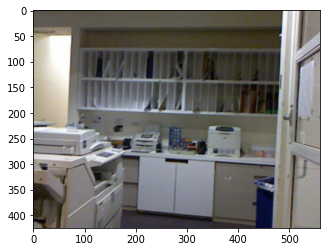

In [8]:
image_path = 'nyu_depth_images/image10.png'
image = Image.open(image_path)
plt.imshow(np.asarray(image))

In [9]:
with open('train.txt') as f:
    train_image_names = f.readlines()

with open('test.txt') as f:
    test_image_names = f.readlines()

In [10]:
len(train_image_names), len(test_image_names)

(795, 654)

In [11]:
with open('qa.894.raw.train.txt') as f:
    train_qa = f.readlines()

with open('qa.894.raw.test.txt') as f:
    test_qa = f.readlines()

In [12]:
train_ques = []
train_imgs = []
train_ans = []

test_ques = []
test_imgs = []
test_ans = []

for i in range(0, len(train_qa), 2):
    ques = train_qa[i]
    toks = ques.split()
    img = toks[-2]
    if not img.startswith('image'):
        continue
    # remove the end tokens: in the <img> ?
    toks = toks[:-4] + ["?"]
    question = " ".join(toks).strip()
    train_imgs.append(img)
    train_ques.append(question)
    train_ans.append(train_qa[i+1])

for i in range(0, len(test_qa), 2):
    ques = test_qa[i]
    toks = ques.split()
    img = toks[-2]
    if not img.startswith('image'):
        continue
    # remove the end tokens: in the <img> ?
    toks = toks[:-4] + ["?"]
    question = " ".join(toks).strip()
    test_imgs.append(img)
    test_ques.append(question)
    test_ans.append(test_qa[i+1])

In [13]:
len(train_imgs), len(train_ques), len(train_ans)

(6794, 6794, 6794)

In [14]:
valid_imgs, test_imgs, valid_ques, test_ques, valid_ans, test_ans = train_test_split(test_imgs, test_ques, test_ans, test_size=0.5, random_state=42)

In [15]:
len(valid_imgs), len(valid_ques), len(valid_ans), len(test_imgs), len(test_ques), len(test_ans)

(2836, 2836, 2836, 2837, 2837, 2837)

In [16]:
len(set(train_imgs)), len(set(test_imgs + valid_imgs))

(794, 653)

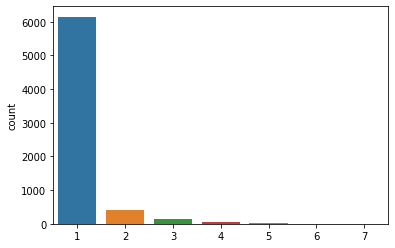

In [17]:
ans_lengths = [len(ans.split()) for ans in train_ans]
sns.countplot(ans_lengths)

Question: what is on the right side of the black telephone and on the left side of the red chair ?
Answer: desk



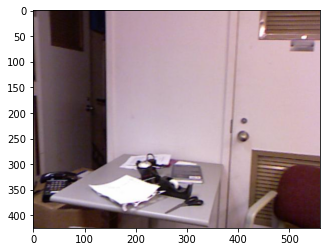

In [18]:
ques = train_ques[0]
ans = train_ans[0]
image_path = f"nyu_depth_images/{train_imgs[0]}.png"
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Question: {ques}")
print(f"Answer: {ans}")

Question: what is on the left side of the cabinet and on the right side of the chair ?
Answer: whiteboard



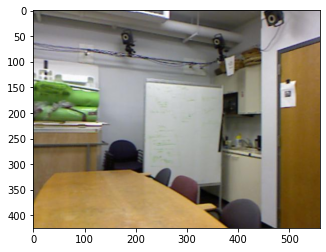

In [19]:
ques = train_ques[10]
ans = train_ans[10]
image_path = f"nyu_depth_images/{train_imgs[10]}.png"
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Question: {ques}")
print(f"Answer: {ans}")

### Image Processing

In [20]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

def resize_images(input_dir, output_dir, size):
    images = os.listdir(input_dir)
    n_images = len(images)
    for iimage, image in enumerate(images):
        try:
            with open(os.path.join(input_dir, image), 'r+b') as f:
                with Image.open(f) as img:
                    img = resize_image(img, size)
                    img.save(os.path.join(output_dir, image), img.format)
        except(IOError, SyntaxError) as e:
            pass
        if (iimage+1) % 100 == 0:
            print("[{}/{}] Resized the images and saved into '{}'."
                    .format(iimage+1, n_images, output_dir))

In [21]:
!mkdir processed_images

In [22]:
size = [448, 448]
input_dir = 'nyu_depth_images'
output_dir = 'processed_images'
resize_images(input_dir, output_dir, size)

[100/1449] Resized the images and saved into 'processed_images'.
[200/1449] Resized the images and saved into 'processed_images'.
[300/1449] Resized the images and saved into 'processed_images'.
[400/1449] Resized the images and saved into 'processed_images'.
[500/1449] Resized the images and saved into 'processed_images'.
[600/1449] Resized the images and saved into 'processed_images'.
[700/1449] Resized the images and saved into 'processed_images'.
[800/1449] Resized the images and saved into 'processed_images'.
[900/1449] Resized the images and saved into 'processed_images'.
[1000/1449] Resized the images and saved into 'processed_images'.
[1100/1449] Resized the images and saved into 'processed_images'.
[1200/1449] Resized the images and saved into 'processed_images'.
[1300/1449] Resized the images and saved into 'processed_images'.
[1400/1449] Resized the images and saved into 'processed_images'.


In [23]:
train_imgs = [f"processed_images/{img}.png" for img in train_imgs]
valid_imgs = [f"processed_images/{img}.png" for img in valid_imgs]
test_imgs = [f"processed_images/{img}.png" for img in test_imgs]

Question: what is in front of the stacked chairs and on the left side of the table ?
Answer: ladder



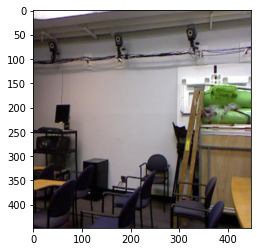

In [24]:
ques = train_ques[15]
ans = train_ans[15]
image_path = train_imgs[15]
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Question: {ques}")
print(f"Answer: {ans}")

### Vocabulary

In [25]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [26]:
def build_vocab(sentences, threshold=5):
    """Build a simple vocabulary wrapper."""
    counter = Counter()
    for i, sent in enumerate(sentences):
        tokens = sent.lower().split()
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized.".format(i+1, len(sentences)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [27]:
ques_vocab = build_vocab(train_ques)
ans_vocab = build_vocab(train_ans)

[1000/6794] Tokenized.
[2000/6794] Tokenized.
[3000/6794] Tokenized.
[4000/6794] Tokenized.
[5000/6794] Tokenized.
[6000/6794] Tokenized.
[1000/6794] Tokenized.
[2000/6794] Tokenized.
[3000/6794] Tokenized.
[4000/6794] Tokenized.
[5000/6794] Tokenized.
[6000/6794] Tokenized.


### VQA Dataset

In [28]:
class VQADataset(data.Dataset):
    def __init__(self, imgs, ques, ans, transform=None):
        self.imgs = imgs
        self.ques = ques
        self.ans = ans
        self.transform = transform
    
    def __len__(self):
        return len(self.ques)
    
    def __getitem__(self, item):
        img = self.imgs[item]
        ques = self.ques[item]
        ans = self.ans[item]

        image = Image.open(img).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        q_tokens = str(ques).lower().split()
        # consider only the first token as the 90% of the data contains only 1 token as answer
        a_token = str(ans).lower().split()[0]

        question = []
        question.append(ques_vocab('<start>'))
        question.extend([ques_vocab(token) for token in q_tokens])
        question.append(ques_vocab('<end>'))
        
        question = torch.Tensor(question)

        answer = [ans_vocab(a_token)]        
        answer = torch.Tensor(answer)

        return image, question, answer

In [29]:
transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))])

In [30]:
train_dataset = VQADataset(train_imgs, train_ques, train_ans, transform)
valid_dataset = VQADataset(valid_imgs, valid_ques, valid_ans, transform)
test_dataset = VQADataset(test_imgs, test_ques, test_ans, transform)

In [31]:
train_dataset[0]

(tensor([[[-0.6281, -0.7137, -0.8849,  ...,  0.0398, -0.0116,  0.0569],
          [-0.5938, -0.6965, -0.9020,  ..., -0.1999, -0.2342, -0.1657],
          [-0.6281, -0.6794, -0.8849,  ..., -0.3369, -0.3883, -0.3198],
          ...,
          [-1.0904, -1.0219, -0.9534,  ..., -1.3987, -1.3815, -1.3644],
          [-1.2959, -1.1760, -1.0733,  ..., -1.4158, -1.3987, -1.3815],
          [-1.5528, -1.4158, -1.2445,  ..., -1.4329, -1.3987, -1.3815]],
 
         [[-0.7577, -0.8452, -1.0728,  ..., -0.4426, -0.5301, -0.4776],
          [-0.7752, -0.8803, -1.1253,  ..., -0.7052, -0.8102, -0.7052],
          [-0.8102, -0.8803, -1.1078,  ..., -0.8803, -0.9678, -0.9153],
          ...,
          [-1.2479, -1.1954, -1.1604,  ..., -1.8606, -1.8431, -1.8256],
          [-1.4230, -1.3354, -1.2479,  ..., -1.8782, -1.8606, -1.8431],
          [-1.6506, -1.5455, -1.4230,  ..., -1.8957, -1.8606, -1.8431]],
 
         [[-0.8110, -0.8110, -0.9330,  ..., -0.5321, -0.5495, -0.4101],
          [-0.7413, -0.7761,

### DataLoaders

In [32]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, questions, answers = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    ques_lengths = [len(ques) for ques in questions]
    qs = torch.zeros(len(questions), max(ques_lengths)).long()
    for i, ques in enumerate(questions):
        end = ques_lengths[i]
        qs[i, :end] = ques[:end]

    # Merge answers (from tuple of 1D tensor to 2D tensor).
    ans_lengths = [len(ans) for ans in answers]
    anss = torch.zeros(len(answers), max(ans_lengths)).long()
    for i, ans in enumerate(answers):
        end = ans_lengths[i]
        anss[i, :end] = ans[:end]

    return images, qs, ques_lengths, anss, ans_lengths


In [33]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn)

valid_data_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, 
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn)

In [34]:
# sample check
sample = next(iter(train_data_loader))

In [35]:
sample[0].shape, sample[1].shape, len(sample[2]), sample[3].shape, len(sample[4])

(torch.Size([32, 3, 448, 448]),
 torch.Size([32, 16]),
 32,
 torch.Size([32, 1]),
 32)

### Input Module

In [66]:
class InputModule(nn.Module):
    def __init__(self, hid_dim, dropout=0.3):
        super().__init__()

        self.hid_dim = hid_dim
        model = models.vgg19(pretrained=True)

        # in_features = model.features[-1].in_features
        # model.classifier = nn.Sequential(
        #     *list(model.classifier.children())[:-1]
        # )
        model = model.features
        for param in model.parameters():
            param.requires_grad_(False)
        self.model = model
        self.fc = nn.Linear(512, hid_dim)
        self.gru = nn.GRU(hid_dim, hid_dim, bidirectional=True, batch_first=True)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, image):
        with torch.no_grad():
            img_features = self.model(image)
            # img_features => [batch_size, 512, 14, 14]
        
        batch_size = image.size(0)
        hid_size = img_features.size(1)
        img_features = img_features.view(batch_size, -1, hid_size)
        # img_features => [batch_size, 196, 512]

        img_emb = self.fc(img_features)
        img_emb = self.dropout(img_emb.tanh())
        # img_emb => [batch_size, 196, hid_dim]

        output, _ = self.gru(img_emb)
        # output => [batch_size, 196, hid_dim * 2]

        combined = output[:, :, :self.hid_dim] + output[:, :, self.hid_dim:]
        # combined => [batch_size, 196, hid_dim]

        return combined

### Question Module

In [37]:
class QuestionModule(nn.Module):
    def __init__(self, vocab_size, hid_dim, dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hid_dim)
        self.gru = nn.GRU(hid_dim, hid_dim, batch_first=True)

        self.dropout = nn.Dropout(dropout)

    def forward(self, question):
        # question => [batch_size, seq_len]

        embed = self.embedding(question)
        embed = self.dropout(embed)
        batch_size = question.size(0)
        # embed => [batch_size, seq_len, emb_dim]

        _, hidden = self.gru(embed)
        # hidden => [1, batch_size, hid_dim]

        question_rep = hidden.transpose(0, 1)
        # question_rep => [batch_size, 1, hid_dim]

        return question_rep

### Episodic Memory Module

#### Attention Mechanism in GRU Cell

In [38]:
class AttentionGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.Wr = nn.Linear(input_size, hidden_size)
        self.Ur = nn.Linear(hidden_size, hidden_size)
        self.W = nn.Linear(input_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, fact, hidden, gate):
        # fact => [batch_size, hid_dim]
        # hidden => [batch_size, hid_dim]
        # gate => [batch_size]

        r = F.sigmoid(self.Wr(fact) + self.Ur(hidden))
        h_tilda = F.tanh(self.W(fact) + r * self.U(hidden))
        
        gate = gate.unsqueeze(1).expand_as(h_tilda)
        # gate => [batch_size, hid_dim]
        
        hidden = gate * h_tilda + (1 - gate) * hidden
        return hidden

#### Attention GRU

In [39]:
class AttentionGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.attn_gru = AttentionGRUCell(input_size, hidden_size)
    
    def forward(self, facts, gates):
        # facts => [batch_size, num_sentences, hid_dim]
        # gates => [batch_size, num_sentences]

        num_sentences = facts.size(1)
        init_hidden = Variable(torch.zeros(self.hidden_size)).to(device)
        # init_hidden => [hid_dim]

        for sent in range(num_sentences):
            fact = facts[:, sent, :]
            gate = gates[:, sent]

            if sent == 0:
                hidden = init_hidden.unsqueeze(0).expand_as(fact)
                # hidden => [batch_size, hid_dim]
            hidden = self.attn_gru(fact, hidden, gate)
        context = hidden
        return context

#### Memory Module

In [40]:
class MemoryModule(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = AttentionGRU(hidden_size, hidden_size)
        self.W1 = nn.Linear(4 * hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, 1)
        self.W_mem = nn.Linear(3 * hidden_size, hidden_size)
    
    def gate_matrix(self, facts, questions, prev_mem):
        # facts => [batch_size, num_sentences, hid_dim]
        # questions => [batch_size, 1, hid_dim]
        # prev_mem => [batch_size, 1, hid_dim]

        batch_size = facts.size(0)
        questions = questions.expand_as(facts)
        prev_mem = prev_mem.expand_as(facts)

        z = torch.cat(
            [
             facts * questions,
             facts * prev_mem,
             torch.abs(facts - questions),
             torch.abs(facts - prev_mem)
            ],
            dim=2
        )
        # z => [batch_size, num_sentences, 4 * hid_dim]
        z = z.view(-1, 4 * self.hidden_size)
        z = self.W2(F.tanh(self.W1(z)))
        z = z.view(batch_size, -1)
        gates = F.softmax(z)

        return gates
    
    def forward(self, facts, questions, prev_mem):
        # facts => [batch_size, num_sentences, hid_dim]
        # questions => [batch_size, 1, hid_dim]
        # prev_mem => [batch_size, 1, hid_dim]
        gates = self.gate_matrix(facts, questions, prev_mem)
        context = self.gru(facts, gates)

        concat = torch.cat([prev_mem.squeeze(1), context, questions.squeeze(1)], dim=1)
        next_memory = F.relu(self.W_mem(concat))
        next_memory = next_memory.unsqueeze(1)

        return next_memory

### Answer Module

In [41]:
class AnswerModule(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.3):
        super().__init__()
        
        self.W = nn.Linear(2 * hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, memory, questions):
        # memory => [batch_size, 1, hid_dim]
        # questions => [batch_size, 1, hid_dim]
        combined = torch.cat([memory, questions], dim=2).squeeze(1)
        out = self.W(combined)
        # out => [batch_size, vocab_size]

        return out

### DMN+

In [60]:
class DMNPlus(nn.Module):
    def __init__(self, hidden_size, vocab_size, ans_vocab_size, num_episodes=3):
        super().__init__()

        self.num_episodes = num_episodes

        self.input_module = InputModule(hidden_size)
        self.question_module = QuestionModule(vocab_size, hidden_size)
        self.episodic_memory_module = MemoryModule(hidden_size)
        self.answer_module = AnswerModule(ans_vocab_size, hidden_size)

    def forward(self, images, questions):
        # images => [batch_size, 3, 448, 448]
        # questions => [batch_size, seq_len]

        encoded_facts = self.input_module(images)
        encoded_ques = self.question_module(questions)

        memory = encoded_ques
        for episode in range(self.num_episodes):
            memory = self.episodic_memory_module(encoded_facts, encoded_ques, memory)
        
        preds = self.answer_module(memory, encoded_ques)
        # preds => [batch_size, ans_vocab_size]
        return preds

### Model

In [77]:
vocab_size = len(ques_vocab)
ans_vocab_size = len(ans_vocab)
hidden_size = 128

model = DMNPlus(hidden_size, vocab_size, ans_vocab_size)
model.to(device)

DMNPlus(
  (input_module): InputModule(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)


### Loss & Optimizer

In [78]:
lr = 1e-2
min_lr = 3e-4
lr_decay=0.5
lr_patience=2

In [79]:
criterion = nn.CrossEntropyLoss()
params = list(model.input_module.fc.parameters()) + list(model.input_module.gru.parameters()) + list(model.question_module.parameters()) + list(model.episodic_memory_module.parameters()) + list(model.answer_module.parameters())
optimizer = torch.optim.Adam(params, lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', lr_decay, lr_patience, verbose=True, min_lr=min_lr)

### Training Method

In [80]:
log_step = 50

In [81]:
def train(model, data_loader):
    model.train()
    epoch_loss = 0
    total_steps = len(data_loader)
    
    for i, (images, questions, _, answers, _) in enumerate(data_loader):
        # zero the gradients
        optimizer.zero_grad()

        images = images.to(device)
        questions = questions.to(device)
        answers = answers.to(device)

        # forward pass
        output = model(images, questions)

        # loss
        loss = criterion(output, answers.squeeze(1))
        epoch_loss += loss.item()
        
        # backward pass
        loss.backward()

        # clip the gradients
        torch.nn.utils.clip_grad_norm_(params, 5.)

        # update parameters
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print(f'Step [{i}/{total_steps}], Loss: {loss.item():.4f}') 
            
    return epoch_loss / total_steps

### Evaluation Method

In [82]:
def evaluate(model, data_loader):
    model.eval()
    epoch_loss = 0

    total_steps = len(data_loader)
    
    with torch.no_grad():
        for i, (images, questions, _, answers, _) in enumerate(data_loader):
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)

            # forward pass
            output = model(images, questions)

            # loss
            loss = criterion(output, answers.squeeze(1))
            epoch_loss += loss.item()

            # Print log info
            if i % log_step == 0:
                print(f'Val Step [{i}/{total_steps}], Loss: {loss.item():.4f}') 
            
    return epoch_loss / total_steps

### Training

In [83]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [84]:
num_epochs = 10

best_valid_loss = float('inf')
for epoch in range(num_epochs):  
    
    start_time = time.time()
    train_loss = train(model, train_data_loader)
    val_loss = evaluate(model, valid_data_loader)
    end_time = time.time()

    scheduler.step(val_loss)
    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {elapsed_mins}m {elapsed_secs}s")
    print(f"\t Train Loss: {train_loss:.3f} | Valid Loss: {val_loss:.3f}")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Step [0/213], Loss: 5.5282
Step [50/213], Loss: 5.2147
Step [100/213], Loss: 4.8261
Step [150/213], Loss: 5.1047
Step [200/213], Loss: 3.0950
Val Step [0/89], Loss: 3.6888
Val Step [50/89], Loss: 3.9916
Epoch: 01 | Time: 10m 55s
	 Train Loss: 4.300 | Valid Loss: 3.655
Step [0/213], Loss: 4.1597
Step [50/213], Loss: 3.6898
Step [100/213], Loss: 3.5945
Step [150/213], Loss: 3.6525
Step [200/213], Loss: 3.2887
Val Step [0/89], Loss: 3.4779
Val Step [50/89], Loss: 3.8477
Epoch: 02 | Time: 10m 55s
	 Train Loss: 3.624 | Valid Loss: 3.422
Step [0/213], Loss: 3.1906
Step [50/213], Loss: 3.5168
Step [100/213], Loss: 3.0462
Step [150/213], Loss: 3.3035
Step [200/213], Loss: 3.6776
Val Step [0/89], Loss: 3.7110
Val Step [50/89], Loss: 4.3914
Epoch: 03 | Time: 10m 56s
	 Train Loss: 3.342 | Valid Loss: 3.510
Step [0/213], Loss: 2.8266
Step [50/213], Loss: 2.8480
Step [100/213], Loss: 2.5801
Step [150/213], Loss: 3.5140
Step [200/213], Loss: 3.3273
Val Step [0/89], Loss: 3.9239
Val Step [50/89], Los

In [85]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [86]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([448, 448], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image


In [87]:
def inference(image_path, question):
    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    q_tokens = str(question).lower().split()
    ques = []
    ques.append(ques_vocab('<start>'))
    ques.extend([ques_vocab(token) for token in q_tokens])
    ques.append(ques_vocab('<end>'))
    
    ques_tensor = torch.LongTensor(ques).to(device)
    ques_tensor = ques_tensor.unsqueeze(0)

    # Generate an caption from the image
    logits = model(image_tensor, ques_tensor)
    scores, preds = logits[0].topk(3, 0, True, True)

    # Print out the image and the generated caption
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    print(question)
    print('-'*50)
    for score, val in zip(scores, preds):
        answer = ans_vocab.idx2word[val.item()]
        if answer == "<unk>":
            continue
        print(f"Pred: {answer}, score: {score.item()}")
    print('-'*50)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


how many black chairs are behind the coffee table ?
--------------------------------------------------
Pred: 2, score: 8.883971214294434
Pred: 3, score: 7.215859413146973
Pred: 4, score: 7.123834133148193
--------------------------------------------------
Actual: 2



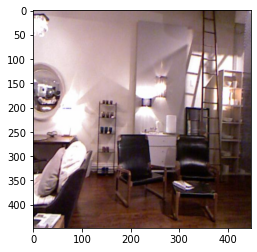

In [88]:
img = train_imgs[150]
ques = train_ques[150]
ans = train_ans[150]

inference(img, ques)
print(f"Actual: {ans}")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


what is the colour of the bath tub ?
--------------------------------------------------
Pred: white, score: 11.319955825805664
Pred: black,, score: 8.920561790466309
Pred: brown, score: 8.16879653930664
--------------------------------------------------
Actual: white



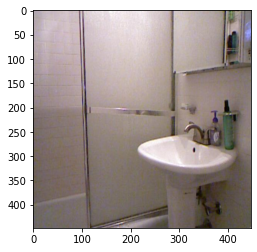

In [89]:
img = train_imgs[1600]
ques = train_ques[1600]
ans = train_ans[1600]

inference(img, ques)
print(f"Actual: {ans}")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


what is behind the bed ?
--------------------------------------------------
Pred: window, score: 6.072701930999756
Pred: wall, score: 5.843307018280029
Pred: blinds, score: 5.637762069702148
--------------------------------------------------
Actual: telescope



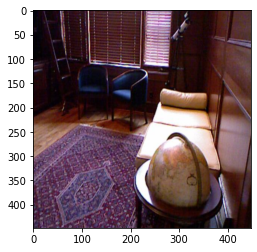

In [90]:
img = train_imgs[4500]
ques = train_ques[4500]
ans = train_ans[4500]

inference(img, ques)
print(f"Actual: {ans}")